## Import library

In [1]:
import os
import pickle

import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
# import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

#### - load features data

In [ ]:
path = "./features_2/"
features_data = []
label_data = []
feature_file = "features.csv"
label_file = "labels.csv"
count = 0

# data = np.loadtxt(path+file, delimiter=',',skiprows=1, usecols=range(1,13))
# features_data.append(data)

import csv

# Open file 
with open(path+feature_file) as file_obj:
    heading = next(file_obj)
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        features_data.append(row[1:])

with open(path+label_file) as file_obj:
    heading = next(file_obj)
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        label_data.append(row)


print(len(features_data), len(label_data))

# lebel_data = label_data[:][1]
# print(label_data)

# print(features_data)

18 4800



#### - load labels data

## Load data

## Assign GPU memory

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data into train and test
- what we have to do for this
 - 동영상 기준? ㅁ
 - 샘플 기준?

In [4]:
labels_Valence = []
labels_Arousal = []
for data in label_data:
    labels_Valence.append(data[1])
for data in label_data:
    labels_Arousal.append(data[2])

In [5]:
# train 80%, test 20%
samples = int(len(features_data)*0.8)
train_data = features_data[:samples]
test_data = features_data[samples:]
train_data_Vlabels = labels_Valence[:samples]
train_data_Alabels = labels_Arousal[:samples]
test_data_Vlabels = labels_Valence[samples:]
test_data_Alabels = labels_Arousal[samples:]
print(len(train_data))
print(len(test_data))

3840
960


In [6]:
x_train = []
x_test = []
timestep = 10
for index in range(len(train_data) - timestep): 
    x_train.append(train_data[index: index + timestep])
for index in range(len(test_data)-timestep):
    x_test.append(test_data[index:index+timestep])
train_data_Vlabels = train_data_Vlabels[timestep:]
test_data_Vlabels = test_data_Vlabels[timestep:]
train_data_Alabels = train_data_Alabels[timestep:]
test_data_Alabels = test_data_Alabels[timestep:]

## Set train and test data

In [7]:
x_train_data = np.array(x_train).astype(np.float32)
y_train_data = np.array(train_data_Vlabels).astype(np.float32)
x_test_data = np.array(x_test).astype(np.float32)
y_test_data = np.array(test_data_Vlabels).astype(np.float32)
print(x_train_data.shape , y_train_data.shape)

# normalize data
Train_nsamples, Train_nx, Train_ny = x_train_data.shape
train_dataset = x_train_data.reshape((Train_nsamples,Train_nx*Train_ny))
Test_nsamples, Test_nx, Test_ny = x_test_data.shape
test_dataset = x_test_data.reshape((Test_nsamples,Test_nx*Test_ny))
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_data = scaler.fit_transform(train_dataset)
x_test_data = scaler.fit_transform(test_dataset)

###
X_train = x_train_data.reshape((Train_nsamples, Train_nx, Train_ny))
X_test = x_test_data.reshape((Test_nsamples, Test_nx, Test_ny))
Y_train = y_train_data.reshape((y_train_data.shape[0], 1))
Y_test = y_test_data.reshape((y_test_data.shape[0], 1))

# print(X_train.shape)
# print(X_test.shape)
# print(Y_train.shape)

(3830, 10, 18) (3830,)


## Build RNN, LSTM, GRU model

In [8]:
# Set Hyperparameters of the model
learning_rate = 0.001
epochs = 200
batch_size=64

In [9]:
X_train[0].shape

(10, 18)

### Binary Classification

In [10]:
# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=256,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               211968    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 475,137
Trainable params: 475,137
Non-trainable params: 0
__________________________________________________

In [11]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test,Y_test),
                  verbose=1)

Epoch 1/200
60/60 [==============================] - 2s 40ms/step - loss: 0.6909 - accuracy: 0.5446 - val_loss: 0.6921 - val_accuracy: 0.5053
Epoch 2/200
60/60 [==============================] - 2s 37ms/step - loss: 0.6901 - accuracy: 0.5399 - val_loss: 0.6977 - val_accuracy: 0.4242
Epoch 3/200
60/60 [==============================] - 2s 37ms/step - loss: 0.6894 - accuracy: 0.5460 - val_loss: 0.7081 - val_accuracy: 0.4358
Epoch 4/200
60/60 [==============================] - 2s 37ms/step - loss: 0.6895 - accuracy: 0.5493 - val_loss: 0.6962 - val_accuracy: 0.4800
Epoch 5/200
60/60 [==============================] - 2s 38ms/step - loss: 0.6879 - accuracy: 0.5454 - val_loss: 0.6923 - val_accuracy: 0.5084
Epoch 6/200
60/60 [==============================] - 2s 39ms/step - loss: 0.6895 - accuracy: 0.5399 - val_loss: 0.6872 - val_accuracy: 0.5768
Epoch 7/200
60/60 [==============================] - 2s 38ms/step - loss: 0.6879 - accuracy: 0.5522 - val_loss: 0.7008 - val_accuracy: 0.4463
Epoch 

### Softmax

## PLOT

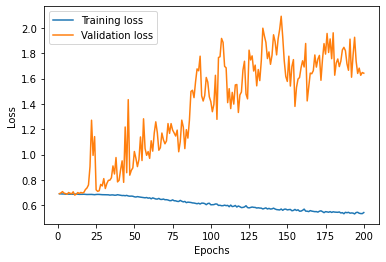

<Figure size 432x288 with 0 Axes>

In [12]:
epoch = np.arange(1,epochs+1)
plt.plot(epoch, history.history['loss'], label='Training loss')
plt.plot(epoch, history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('BinaryClassification_Dense2-Loss')

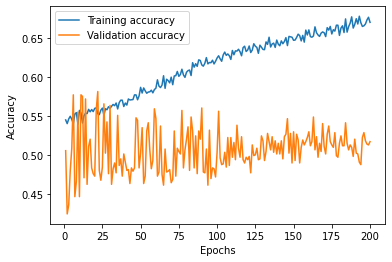

<Figure size 432x288 with 0 Axes>

In [13]:
epoch = np.arange(1,epochs+1)
plt.plot(epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('BinaryClassification_Dense2-Accuracy')

In [14]:
model.save('BinaryClassification_Dense2.h5')